# Air Quality and Social Justice

In this notebook we explore the relationship between air quality (pm25 and ozone) and income and elevation. This will allow us to explore questions related to social justice, such as is air pollution exposure equally distributed across different socio-economic groups.

#### Tell our plotting routines to draw the graphics in our web browser

In [20]:
%matplotlib inline

### Import packages that we are going to use
#### These include

* [Pandas](http://pandas.pydata.org/index.html): A package for reading and manipulating tabular data.
* [Seaborn](http://seaborn.pydata.org/index.html): Seaborn is a plotting package that provides "nice" pre-defined plots for a variety of common graph types.
* [statsmodels](http://www.statsmodels.org/stable/): This package provides a number of common statistical functions for analysing data.


In [46]:
import pandas as pd
import seaborn as sns
import statsmodels
import statsmodels.formula.api as smf
import patsy
import os
import matplotlib.pyplot as plt

#### Tell our program where our data are located

In [22]:
DATADIR = "/home/jovyan/DATA/AirQuality"

In [53]:
os.listdir(DATADIR)

['Class_Ozone_Data-1.csv', 'Class_Ozone_Data.csv', 'Class_PM25_Data.csv']

### What are these data

In our data directory we have two **csv** files. csv stands for **C**omma **S**eparated **V**alues. For different regions in the Salt Lake valley (zip code), we have computed the average

1. Income
1. Elevation
1. pm25 levels for March 8, 2016
1. ozone levels at 10:00 am and 3:00 PM from August 2016.

These files have been created by Dr. Daniel L. Mendoza at the University of Utah.

## Use Pandas to read in the data

Pandas reads the data into a Pandas **dataframe** which we assing to the variable ``pm25``. Dataframes have two methods for looking at the data ``head()`` and ``tail()``

In [56]:
pm25 = pd.read_csv(os.path.join(DATADIR, "Class_PM25_Data.csv"))
pm25.head(), pm25.tail()

(   Block_Group_ID   Income    Elevation  PM25_MAR_8
 0    4.903510e+11  43646.0  1307.687012    3.651442
 1    4.903510e+11  35775.0  1296.852051    3.840161
 2    4.903510e+11  38281.0  1289.720459    3.957534
 3    4.903510e+11  64091.0  1301.926758    3.945700
 4    4.903510e+11  37083.0  1296.852051    3.648757,
     Block_Group_ID   Income    Elevation  PM25_MAR_8
 60    4.903510e+11  69188.0  1321.630859    4.409883
 61    4.903510e+11  69493.0  1312.114014    3.989309
 62    4.903510e+11  92551.0  1557.853394    1.537066
 63    4.903510e+11  60817.0  1552.666016    2.252555
 64    4.903600e+11      NaN  1275.227905    3.717521)

#### Notice the ``NaN`` value for Income in our last data row

Pandas uses ``NaN`` (Not a number) to represent missing values. That is our data file did not have an income value for the last row. There are a variety of approaches for dealing with missing data, but we are just going to drop that value using the Pandas dataframe ``dropna`` method.



In [58]:
pm25 = pm25.dropna()
pm25.tail()

,Block_Group_ID,Income,Elevation,PM25_MAR_8
59,4.903510e+11,35375.0,1305.029541,3.595146
60,4.903510e+11,69188.0,1321.630859,4.409883
61,4.903510e+11,69493.0,1312.114014,3.989309
62,4.903510e+11,92551.0,1557.853394,1.537066
63,4.903510e+11,60817.0,1552.666016,2.252555


### Now Let's Repeat this with the Ozone Data

In [60]:
ozone = pd.read_csv(os.path.join(DATADIR, "Class_Ozone_Data.csv"))
ozone.tail()

,Block_Group_ID,Income,Elevation,Ozone_AUG_10,Ozone_AUG_15
60,490351142001,69188.0,1321.630859,30.320732,57.617152
61,490351142002,69493.0,1312.114014,31.675820,59.208955
62,490351152091,92551.0,1557.853394,36.326890,58.199097
63,490351152092,60817.0,1552.666016,36.182543,57.752619
64,490359800001,NaN,1275.227905,34.025492,56.458415


In [61]:
ozone = ozone.dropna()

## Let's plot some of our data

In our introduction to Python we plotted using Pandas directly. When we explored the relationship of wind and air pollution, we used [matplotlib]() to plot. In this notebook we are going to explore using [Seaborn](http://seaborn.pydata.org/index.html) to plot data.

Our first plot is going to be to look at a [histogram](https://en.wikipedia.org/wiki/Histogram) of our particle measurements.

Seaborn has several options for plotting histograms. We are going to use the ``distplot()`` function. 

* What happens when you change ```kde``` from False to True?

/Users/brian/anaconda/envs/6950/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


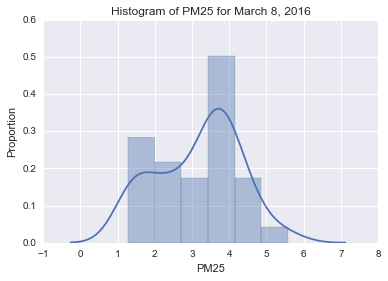

In [68]:
fig1, ax1 = plt.subplots(1)
sns.distplot(pm25["PM25_MAR_8"], ax=ax1, kde=True)
ax1.set_xlabel("PM25")
ax1.set_ylabel("Proportion")
ax1.set_title("Histogram of PM25 for March 8, 2016")


``jointplot`` has a number of options that determine what kind of joint plot to generate. The default is "scatter" but you can use any of the following:

* "scatter"
* "reg"
* "resid"
* "kde"
* "hex"

You can also change which color you want to plot.

/Users/brian/anaconda/envs/6950/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


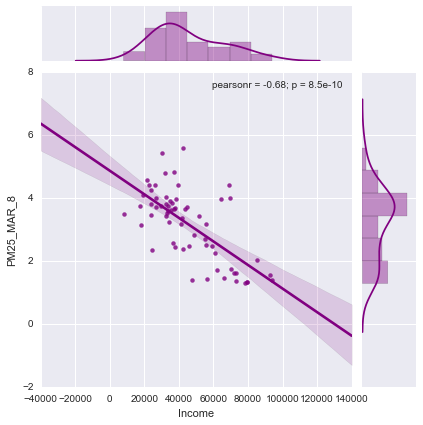

In [72]:
sns.jointplot(x="Income", y="PM25_MAR_8", data=pm25, kind="reg",
             color='purple');

### We can see that there is a reasonable linear relationship between polution and income
#### Let's quantify this

We will use ``statsmodels`` to do [ordinary least squares regression](https://en.wikipedia.org/wiki/Ordinary_least_squares).

```Python
mod = smf.ols(formula='PM25_MAR_8 ~ Income', data=pm25)
```

* Use Patsy to specify what our regressions is. This formula is stating a linear relationship between ``PM25_MAR_8`` to ``Income``.

```Python
'PM25_MAR_8 ~ Income'
```
```Python
data=pm25
```

* Use the ``pm25`` dataframe
* ``mod.fit()`` fits the model to the data
* ```print(res.summary())``` provides a detailed report on how well the model fit the data.

In [48]:
mod = smf.ols(formula='PM25_MAR_8 ~ Income', data=pm25)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             PM25_MAR_8   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     52.32
Date:                Mon, 22 May 2017   Prob (F-statistic):           8.48e-10
Time:                        23:22:46   Log-Likelihood:                -77.678
No. Observations:                  64   AIC:                             159.4
Df Residuals:                      62   BIC:                             163.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      4.8552      0.256     18.981      0.0

### This is a lot of information. What are the key points?

#### Let's start by looking at our overall model.

* **Prob (F-statistic):**           8.48e-10 ($8.48e^{-10}$). 
    * This is the probability that the linear relationship between our variables is purely due to chance.
* **R-squared:**                       0.458
    * This is the proportion of the variability in our data that is explained by our model.
* **Cond. No.**                     1.22e+05 ($1.22e^{05}$)
    * A large condition number indicates numeric problems with our model/data and mean the results are less reliable.

#### Now let's look at our ``Income`` variable

* **coef**=-3.74e-05 ($-3.74e^{-05}$). This is the slope of the line. The slope is negative, meaning as income **increases** air pollution **decreases.**
* **P**=0.000. This is the "p-value" and describes the probability that the linear relationship is just random chance.


## Let's repeat this for the relationship between ``Income`` and ``Elevation``

/Users/brian/anaconda/envs/6950/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


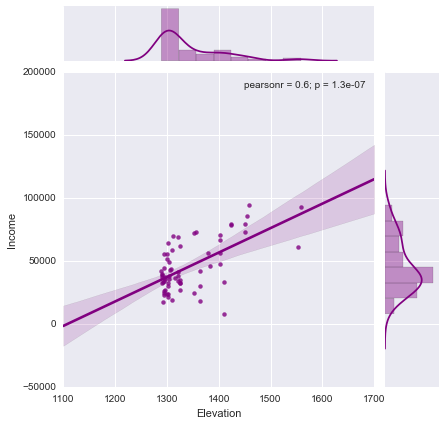

In [49]:
sns.jointplot(y="Income", x="Elevation", data=pm25, kind="reg",
             color='purple');

### The relationship between ``Income`` and ``Elevation`` is strong
### Now let us use ``Elevation`` to predict ``PM25_MAR_8``

In [73]:
mod = smf.ols(formula='PM25_MAR_8 ~ Elevation', data=pm25)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             PM25_MAR_8   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     50.84
Date:                Tue, 23 May 2017   Prob (F-statistic):           1.28e-09
Time:                        12:35:41   Log-Likelihood:                -78.095
No. Observations:                  64   AIC:                             160.2
Df Residuals:                      62   BIC:                             164.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     19.1668      2.247      8.531      0.0

### Can we build a model that uses *both* ``Elevation`` and ``Income`` to

In [52]:
mod = smf.ols(formula='PM25_MAR_8 ~ Elevation + Income + Elevation:Income', data=pm25)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             PM25_MAR_8   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     27.61
Date:                Mon, 22 May 2017   Prob (F-statistic):           2.42e-11
Time:                        23:32:50   Log-Likelihood:                -69.505
No. Observations:                  64   AIC:                             147.0
Df Residuals:                      60   BIC:                             155.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept           22.4080      6.418  

### What happens when we include both predictors?

# Now let's look at Ozone

![Ozone](https://upload.wikimedia.org/wikipedia/commons/thumb/2/28/Ozone_cycle.svg/1280px-Ozone_cycle.svg.png)

## We have ozone measurements at two times: 10:00 AM and 3:00 PM (15:00)

#### How are these measurements different? (use ``distplot()`` to explore the histograms)
#### What do you think might account for these differences?

/Users/brian/anaconda/envs/6950/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


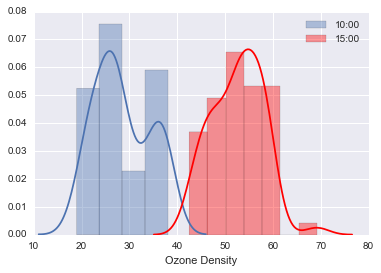

In [89]:
fig2, ax2 = plt.subplots(1)
sns.distplot(ozone["Ozone_AUG_10"], ax=ax2, label="10:00")
sns.distplot(ozone["Ozone_AUG_15"], ax=ax2, color='r', label="15:00")
ax2.set_xlabel("Ozone Density")
ax2.legend()

## Ozone vs pm25

#### Using the same plotting and statistical functions we used above explore the relationship between ozone and income/elevation
#### How does the relationship differ from pm25?

/Users/brian/anaconda/envs/6950/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


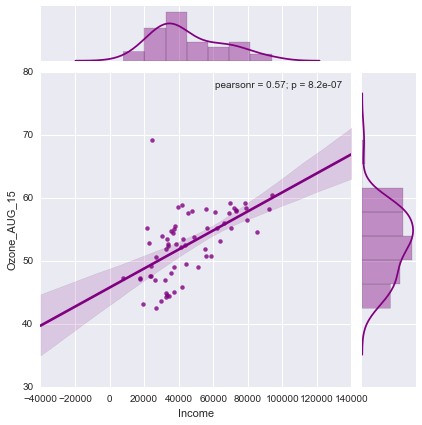

In [77]:
sns.jointplot(x="Income", y="Ozone_AUG_15", data=ozone, kind="reg",
             color='purple');

In [91]:
mod = smf.ols(formula='Ozone_AUG_15 ~ Elevation', data=ozone)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           Ozone_AUG_15   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     8.786
Date:                Tue, 23 May 2017   Prob (F-statistic):            0.00430
Time:                        18:43:55   Log-Likelihood:                -193.18
No. Observations:                  64   AIC:                             390.4
Df Residuals:                      62   BIC:                             394.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     12.3968     13.569      0.914      0.3

In [92]:
mod = smf.ols(formula='Ozone_AUG_15 ~ Income', data=ozone)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           Ozone_AUG_15   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     30.06
Date:                Tue, 23 May 2017   Prob (F-statistic):           8.16e-07
Time:                        18:44:03   Log-Likelihood:                -184.78
No. Observations:                  64   AIC:                             373.6
Df Residuals:                      62   BIC:                             377.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     45.7387      1.363     33.548      0.0